# Explore here

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
df = pd.read_csv("/workspaces/Timeseries_VP/data/raw/Aquifer_Petrignano.csv")
df.head()

,Date,Rainfall_Bastia_Umbra,Depth_to_Groundwater_P24,Depth_to_Groundwater_P25,Temperature_Bastia_Umbra,Temperature_Petrignano,Volume_C10_Petrignano,Hydrometry_Fiume_Chiascio_Petrignano
0,14/03/2006,NaN,-22.48,-22.18,NaN,NaN,NaN,NaN
1,15/03/2006,NaN,-22.38,-22.14,NaN,NaN,NaN,NaN
2,16/03/2006,NaN,-22.25,-22.04,NaN,NaN,NaN,NaN
3,17/03/2006,NaN,-22.38,-22.04,NaN,NaN,NaN,NaN
4,18/03/2006,NaN,-22.60,-22.04,NaN,NaN,NaN,NaN


In [4]:
df = df[df.Rainfall_Bastia_Umbra.notna()].reset_index(drop=True)

In [5]:
df = df.drop(['Depth_to_Groundwater_P24', 'Temperature_Petrignano'], axis=1)

In [6]:
df.columns = ['date', 'rainfall', 'depth_to_groundwater', 'temperature', 'drainage_volume', 'river_hydrometry']

In [7]:
targets = ['depth_to_groundwater']
features = [feature for feature in df.columns if feature not in targets]
df.head()

,date,rainfall,depth_to_groundwater,temperature,drainage_volume,river_hydrometry
0,01/01/2009,0.0,-31.14,5.2,-24530.688,2.4
1,02/01/2009,0.0,-31.11,2.3,-28785.888,2.5
2,03/01/2009,0.0,-31.07,4.4,-25766.208,2.4
3,04/01/2009,0.0,-31.05,0.8,-27919.296,2.4
4,05/01/2009,0.0,-31.01,-1.9,-29854.656,2.3


In [8]:
from datetime import datetime, date  

df['date'] = pd.to_datetime(df['date'], format = '%d/%m/%Y')
df.head().style.set_properties(subset=['date'], **{'background-color': 'dodgerblue'})

,date,rainfall,depth_to_groundwater,temperature,drainage_volume,river_hydrometry
0,2009-01-01 00:00:00,0.000000,-31.140000,5.200000,-24530.688000,2.400000
1,2009-01-02 00:00:00,0.000000,-31.110000,2.300000,-28785.888000,2.500000
2,2009-01-03 00:00:00,0.000000,-31.070000,4.400000,-25766.208000,2.400000
3,2009-01-04 00:00:00,0.000000,-31.050000,0.800000,-27919.296000,2.400000
4,2009-01-05 00:00:00,0.000000,-31.010000,-1.900000,-29854.656000,2.300000


## Data Visualization

### Features:

**Rainfall** indicates the quantity of rain falling (mm)

**Temperature** indicates the temperature (°C)

**Volume** indicates the volume of water taken from the drinking water treatment plant (m³)

**Hydrometry** indicates the groundwater level (m)

**Target**: Depth to Groundwater indicates the groundwater level (m from the ground floor)

Rainfall over time

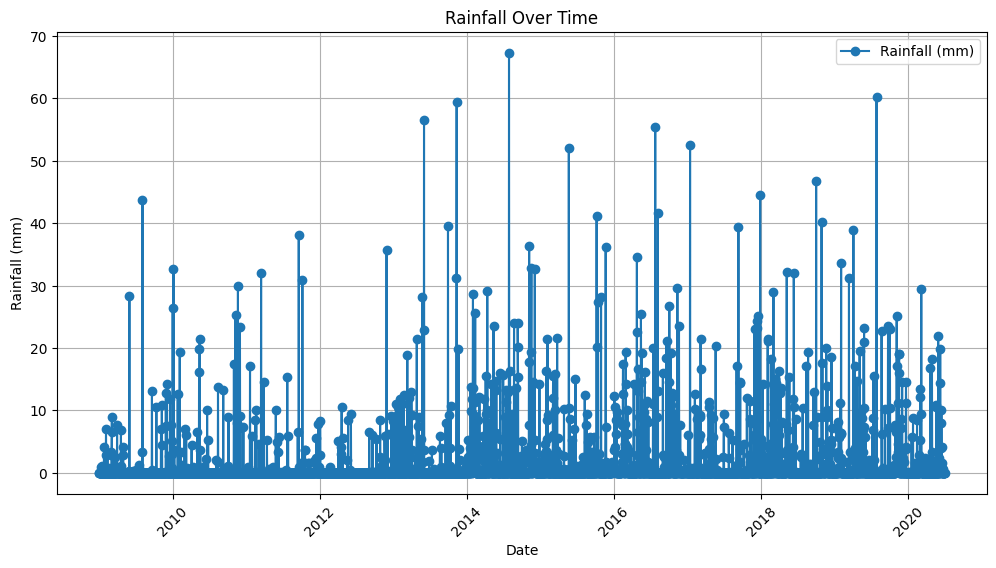

In [9]:

plt.figure(figsize=(12, 6))
plt.plot(df['date'], df['rainfall'], marker='o', label='Rainfall (mm)')
plt.title('Rainfall Over Time')
plt.xlabel('Date')
plt.ylabel('Rainfall (mm)')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()

Temperature Over Time

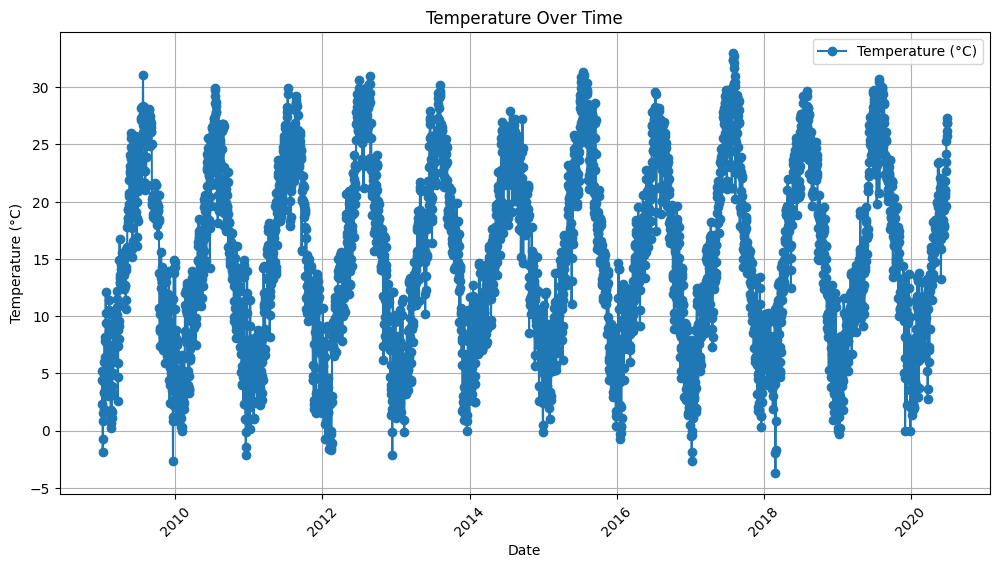

In [10]:
plt.figure(figsize=(12, 6))
plt.plot(df['date'], df['temperature'], marker='o', label='Temperature (°C)')
plt.title('Temperature Over Time')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()

Volume Over Time

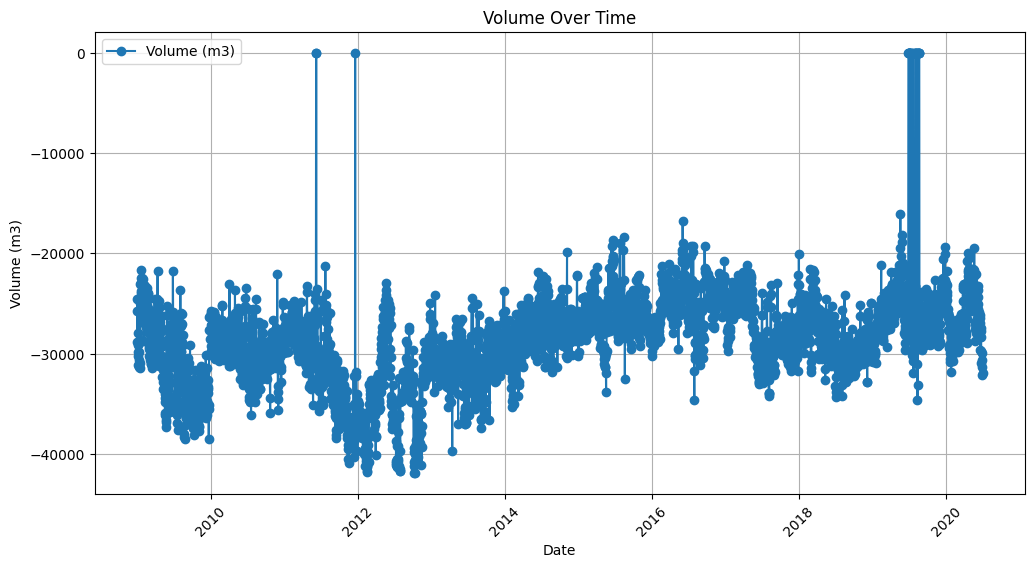

In [11]:
plt.figure(figsize=(12, 6))
plt.plot(df['date'], df['drainage_volume'], marker='o', label='Volume (m3)')
plt.title('Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Volume (m3)')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()

Hidrometry over time

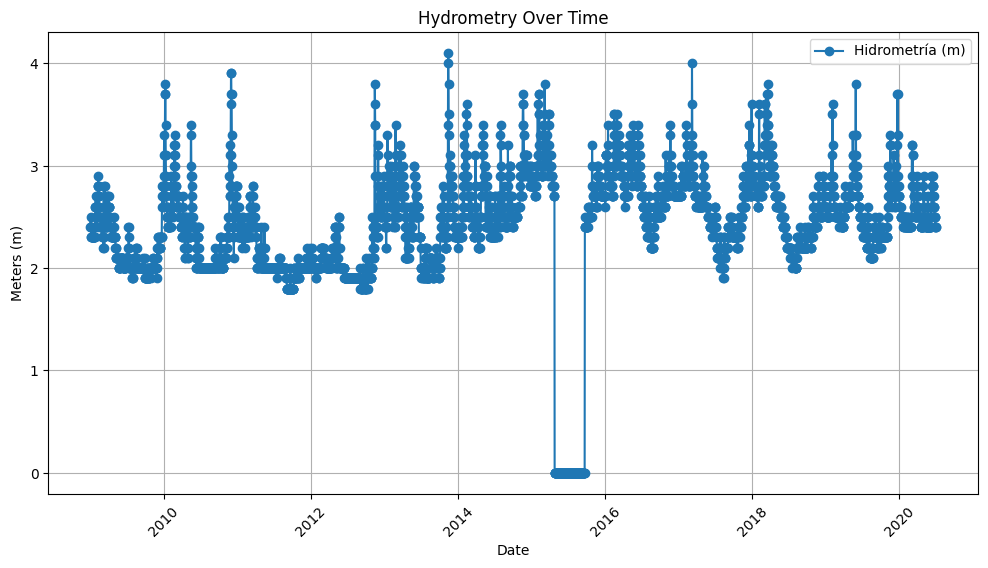

In [12]:
plt.figure(figsize=(12, 6))
plt.plot(df['date'], df['river_hydrometry'], marker='o', label='Hidrometría (m)')
plt.title('Hydrometry Over Time')
plt.xlabel('Date')
plt.ylabel('Meters (m)')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()

En varios casos, se ve picos en los datos que no son consistentes. Mi sospecha, observando los estudios de otros en Kaggle, es que hay varios valores nulos en los datos. 


In [13]:
df.isna().sum()

date                     0
rainfall                 0
depth_to_groundwater    27
temperature              0
drainage_volume          1
river_hydrometry         0
dtype: int64

Se puede ver que en el último gráfico, hay un bajón debido a los datos faltantes. Los trataremos mas tarde, antes me gustaría graficar un plot multilinear para ver lluvia, temperatura, y profundidad para poder ver como interactuan en el tiempo. 

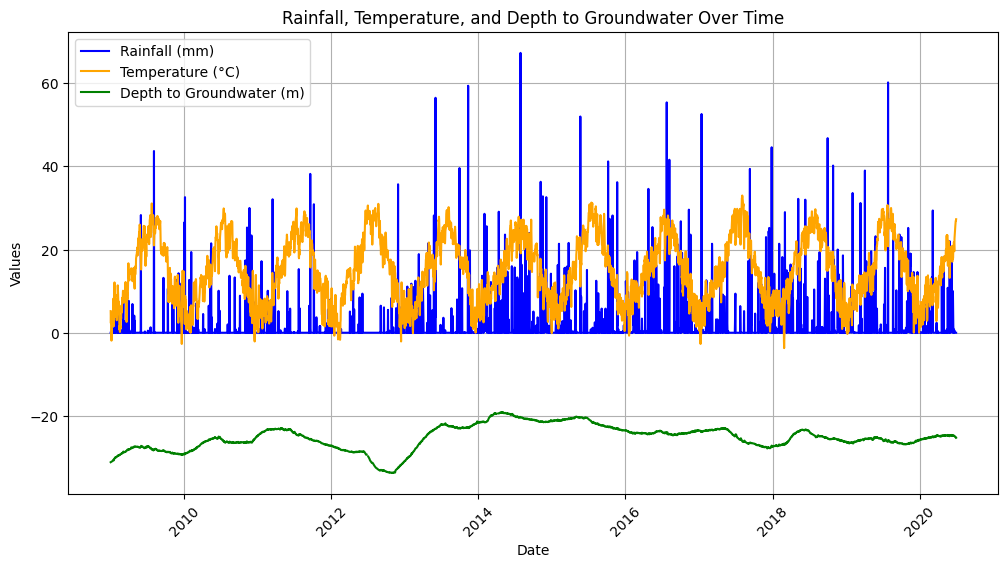

In [14]:
plt.figure(figsize=(12, 6))
plt.plot(df['date'], df['rainfall'], label='Rainfall (mm)', color='blue')
plt.plot(df['date'], df['temperature'], label='Temperature (°C)', color='orange')
plt.plot(df['date'], df['depth_to_groundwater'], label='Depth to Groundwater (m)', color='green')
plt.title('Rainfall, Temperature, and Depth to Groundwater Over Time')
plt.xlabel('Date')
plt.ylabel('Values')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()

Y con el fin de tener aún mas datos, un mapa de correlaciones también podría ayudarnos a tener una visión mas certera sobre el asunto: 

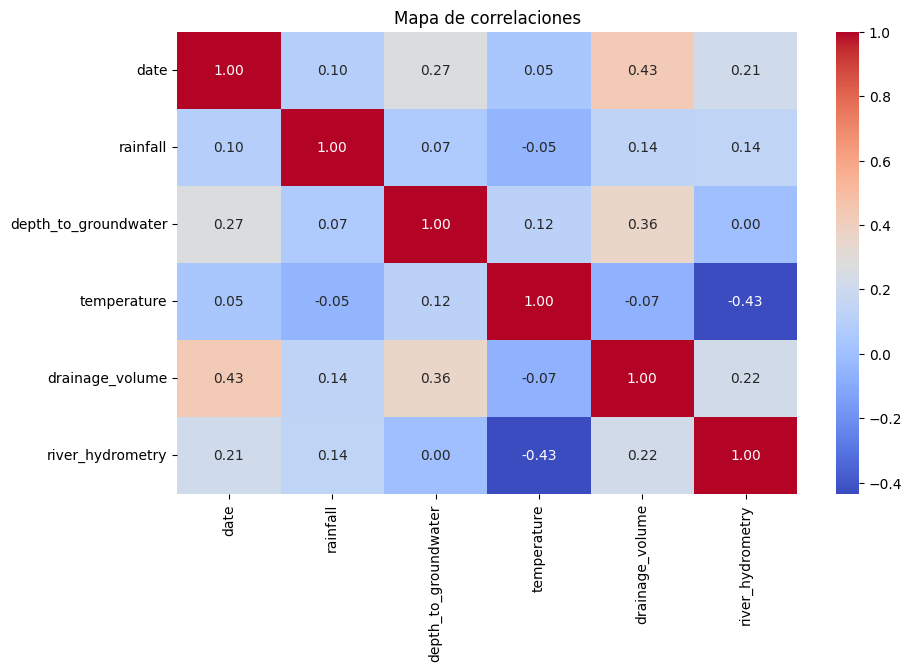

In [15]:
plt.figure(figsize=(10, 6))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Mapa de correlaciones')
plt.show()

Es particularmente llamativo: 

- La correlación negativa entre hidrometría y la temperatura del agua
- Que la correlación entre la fecha y el drenaje es el mismo número pero en positivo 
- La evidente correlación entre drenaje y profundidad del agua. Cuanto mas agua se drena, mayor profundidad

Volviendo al tema de los datos faltantes: 

In [16]:
df.isna().sum()

date                     0
rainfall                 0
depth_to_groundwater    27
temperature              0
drainage_volume          1
river_hydrometry         0
dtype: int64

Tenemos varias alternativas para poder tratarlos, me resulta super instructiva la manera en la que en la solución se muestra, donde se exploran los 4 posibles escenarios: 

1 - Sustituir NaN con ceros

2 - Sustituir NaN con la media

3 - Sustituir NaN con el último valor usando .ffill()

4 - Sustituir NaN con Linearly Interpolated Value con .interpolate()


Así que sin esconderlo, voy a decir que he copiado el código porque visualmente me parece muy indicativo: 

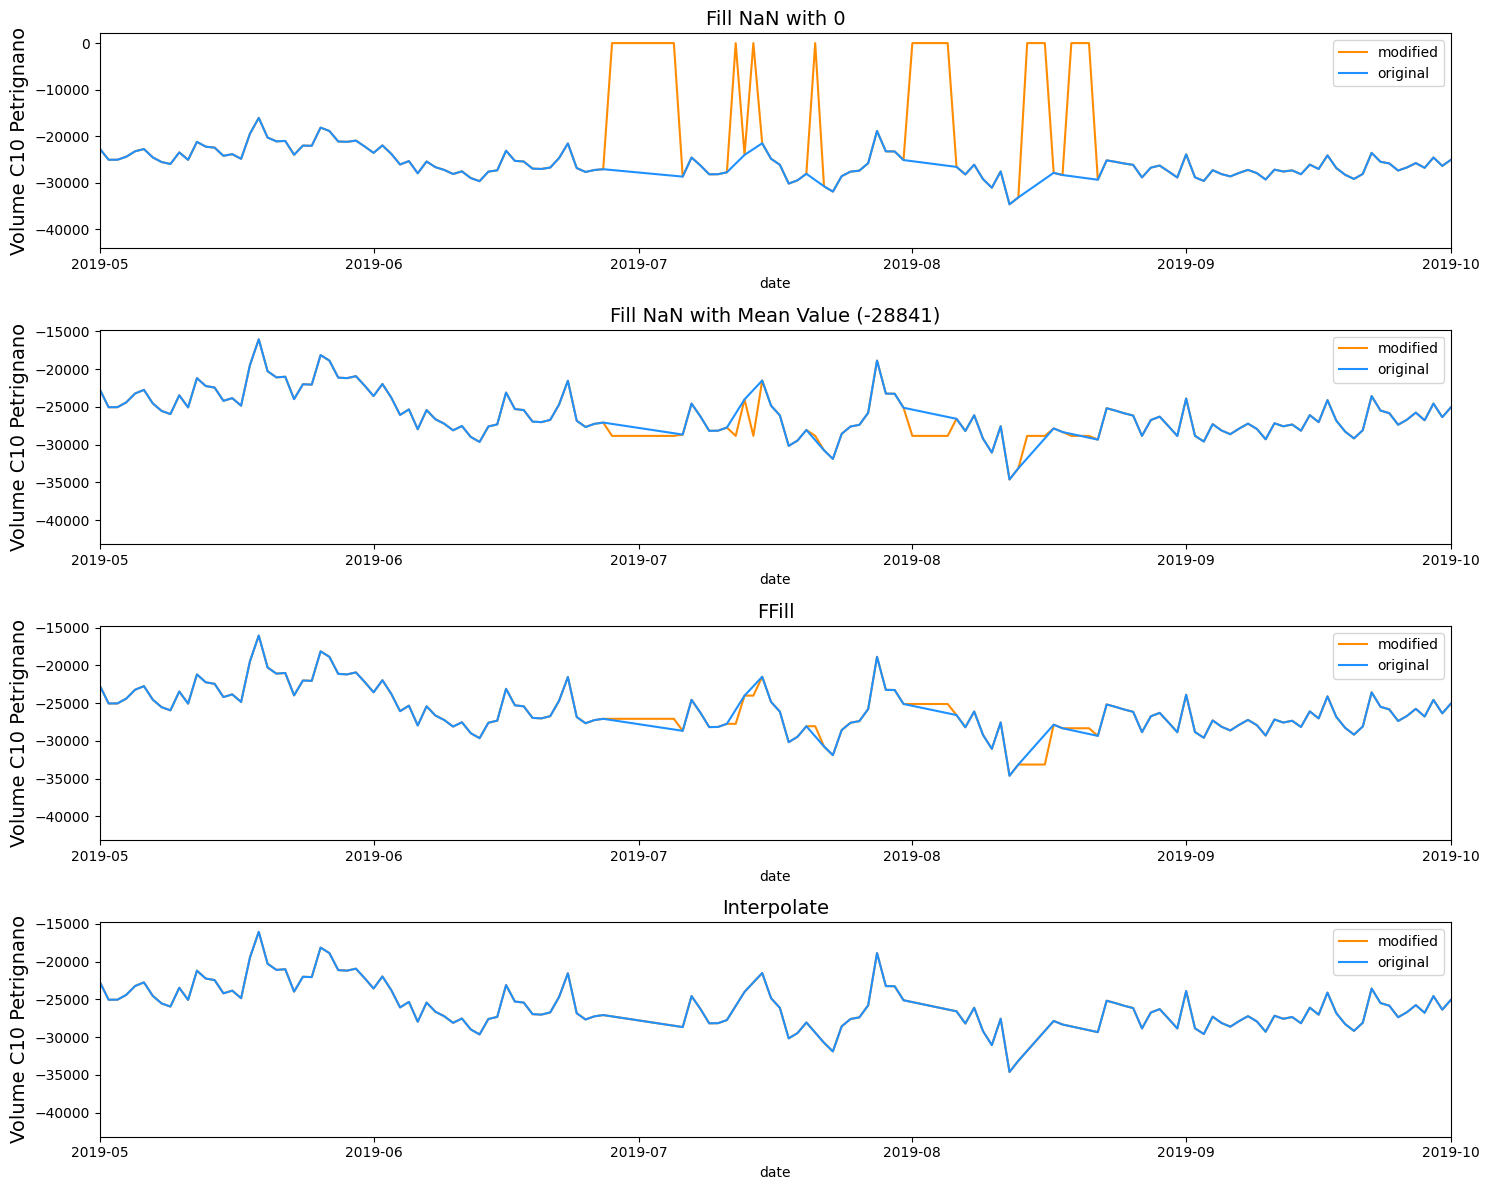

In [17]:
old_hydrometry = df['river_hydrometry'].copy()
df['river_hydrometry'] = df['river_hydrometry'].replace(0, np.nan)
old_drainage = df['drainage_volume'].copy()
df['drainage_volume'] = df['drainage_volume'].replace(0, np.nan)

f, ax = plt.subplots(nrows=4, ncols=1, figsize=(15, 12))

sns.lineplot(x=df['date'], y=df['drainage_volume'].fillna(0), ax=ax[0], color='darkorange', label = 'modified')
sns.lineplot(x=df['date'], y=df['drainage_volume'].fillna(np.inf), ax=ax[0], color='dodgerblue', label = 'original')
ax[0].set_title('Fill NaN with 0', fontsize=14)
ax[0].set_ylabel(ylabel='Volume C10 Petrignano', fontsize=14)

mean_drainage = df['drainage_volume'].mean()
sns.lineplot(x=df['date'], y=df['drainage_volume'].fillna(mean_drainage), ax=ax[1], color='darkorange', label = 'modified')
sns.lineplot(x=df['date'], y=df['drainage_volume'].fillna(np.inf), ax=ax[1], color='dodgerblue', label = 'original')
ax[1].set_title(f'Fill NaN with Mean Value ({mean_drainage:.0f})', fontsize=14)
ax[1].set_ylabel(ylabel='Volume C10 Petrignano', fontsize=14)

sns.lineplot(x=df['date'], y=df['drainage_volume'].ffill(), ax=ax[2], color='darkorange', label = 'modified')
sns.lineplot(x=df['date'], y=df['drainage_volume'].fillna(np.inf), ax=ax[2], color='dodgerblue', label = 'original')
ax[2].set_title(f'FFill', fontsize=14)
ax[2].set_ylabel(ylabel='Volume C10 Petrignano', fontsize=14)

sns.lineplot(x=df['date'], y=df['drainage_volume'].interpolate(), ax=ax[3], color='darkorange', label = 'modified')
sns.lineplot(x=df['date'], y=df['drainage_volume'].fillna(np.inf), ax=ax[3], color='dodgerblue', label = 'original')
ax[3].set_title(f'Interpolate', fontsize=14)
ax[3].set_ylabel(ylabel='Volume C10 Petrignano', fontsize=14)

for i in range(4):
    ax[i].set_xlim([date(2019, 5, 1), date(2019, 10, 1)])
    
plt.tight_layout()
plt.show()

Como se puede ver, donde menos estridencia hay, y menos presencia del color naranja, es a la hora de interpolar los datos. 

In [18]:
df['drainage_volume'] = df['drainage_volume'].interpolate()
df['river_hydrometry'] = df['river_hydrometry'].interpolate()
df['depth_to_groundwater'] = df['depth_to_groundwater'].interpolate()

## Resampling
En nuestro caso con el fin de ampliar los datos, vamos a hacer la comparativa entre dias, semanas y meses

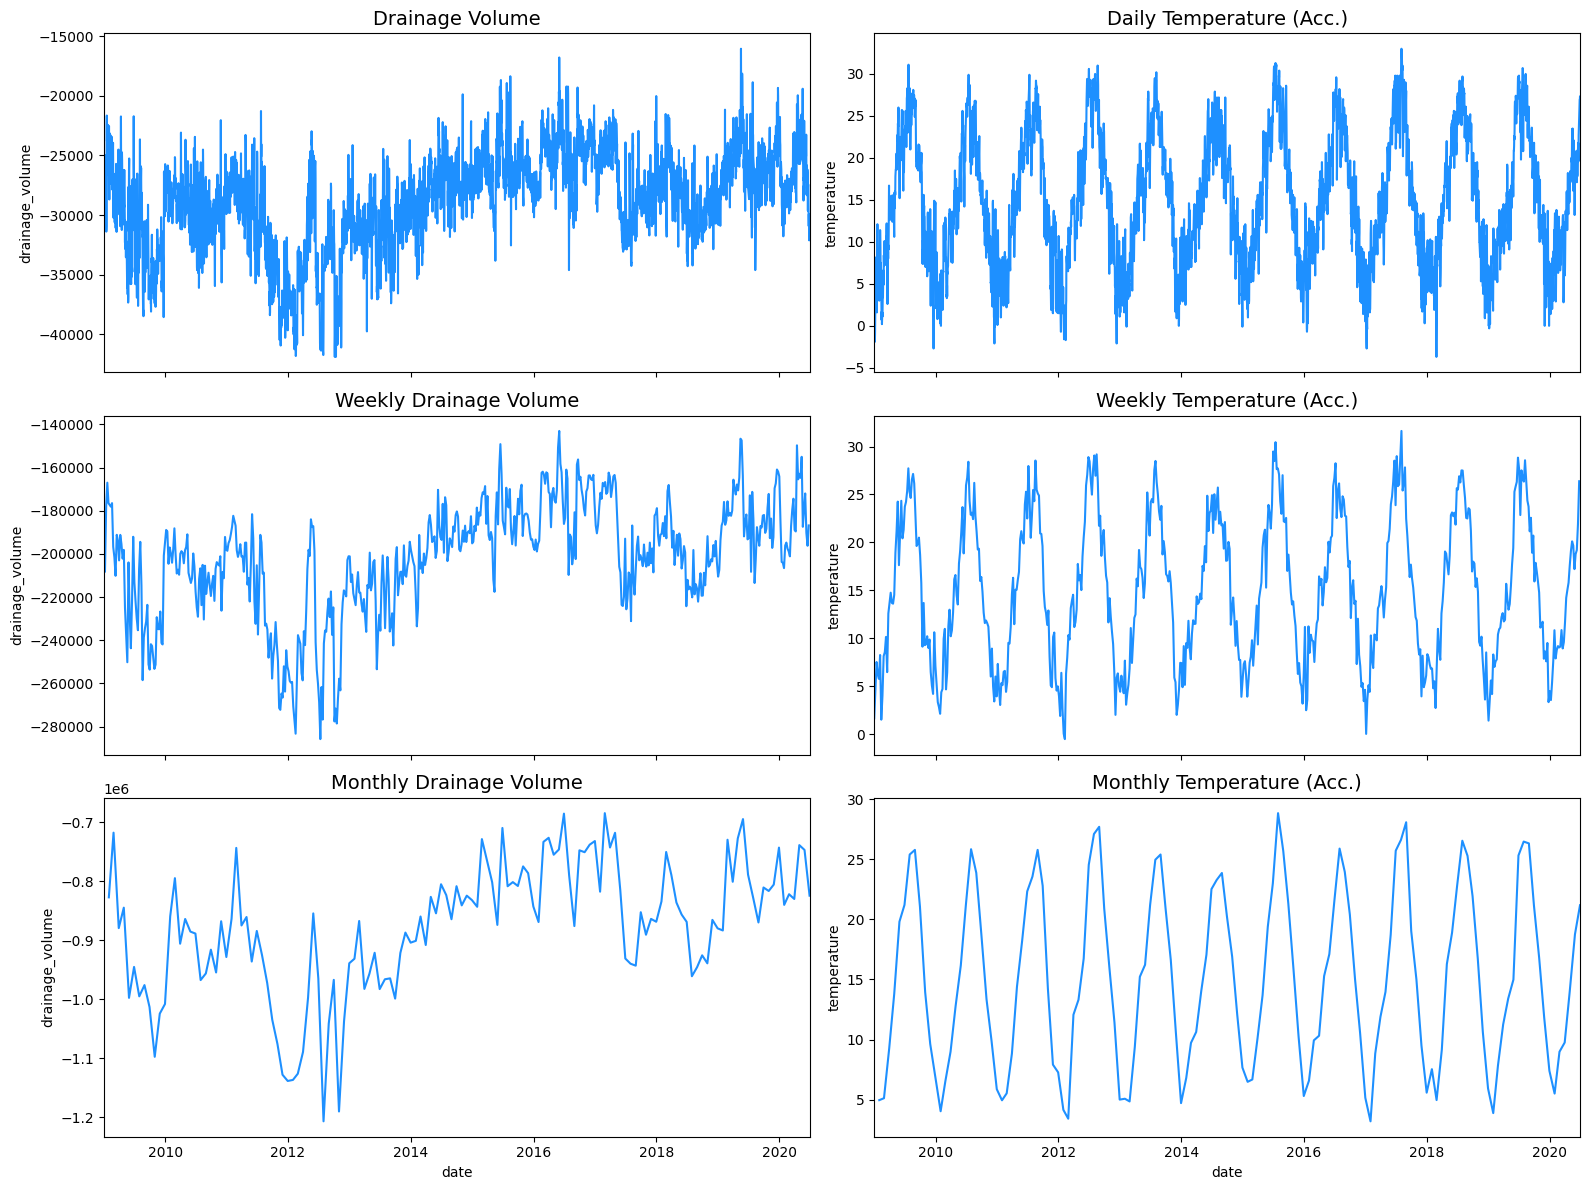

In [19]:

fig, ax = plt.subplots(ncols=2, nrows=3, sharex=True, figsize=(16, 12))

columns = ['drainage_volume', 'temperature']
resampling_frequencies = ['D', '7D', 'ME']  # Daily, Weekly, Monthly
titles = [
    'Drainage Volume',
    'Weekly Drainage Volume',
    'Monthly Drainage Volume',
    'Daily Temperature (Acc.)',
    'Weekly Temperature (Acc.)',
    'Monthly Temperature (Acc.)'
]

for col_index, column in enumerate(columns):
    # En base a los dias (Upsampling)
    sns.lineplot(x=df['date'], y=df[column], color='dodgerblue', ax=ax[0, col_index])
    ax[0, col_index].set_title(titles[col_index * 3], fontsize=14)

    # Resample and plot for 7D and M
    for freq_index, freq in enumerate(resampling_frequencies[1:], start=1):
        resampled_df = df[['date', column]].resample(freq, on='date').sum().reset_index(drop=False) if column == 'drainage_volume' else df[['date', column]].resample(freq, on='date').mean().reset_index(drop=False)
        sns.lineplot(x=resampled_df['date'], y=resampled_df[column], color='dodgerblue', ax=ax[freq_index, col_index])
        ax[freq_index, col_index].set_title(titles[col_index * 3 + freq_index], fontsize=14)

    # Set x-axis limits for all rows in the current column
    for i in range(3):
        ax[i, col_index].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])

plt.tight_layout()
plt.show()

Como se puede ver, trabajar con datos semanales es una buena opción. Así que mantendremos esos datos.

In [20]:
downsample = df[['date',
                 'depth_to_groundwater', 
                 'temperature',
                 'drainage_volume', 
                 'river_hydrometry',
                 'rainfall'
                ]].resample('7D', on='date').mean().reset_index(drop=False)

df = downsample.copy()

## Stationarity 
 Para poder comprobar si los datos son estacionarios, podemos ejecutar el Dickey-Fuller Test y sacar estadísticas: 